In [ ]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.utils import shuffle

X, y1 = make_classification(n_samples=10, n_features=100, n_informative=30, n_classes=3, random_state=1)
y2 = shuffle(y1, random_state=1)
y3 = shuffle(y1, random_state=2)
Y = np.vstack((y1, y2, y3)).T

forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=2)
multi_target_forest.fit(X, Y).predict(X)


array([[2, 2, 0],
       [1, 2, 1],
       [2, 1, 0],
       [0, 0, 2],
       [0, 2, 1],
       [0, 0, 2],
       [1, 1, 0],
       [1, 1, 1],
       [0, 0, 2],
       [2, 0, 0]])

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features
y = air_quality.data.targets

# metadata
print(air_quality.metadata)

# variable information
print(air_quality.variables)


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

In [ ]:
import pandas as pd
import numpy as np

# Assume X and y are loaded from ucimlrepo fetch_ucirepo as pandas DataFrames

# Example: Select relevant continuous target columns for classification
# CO(GT), NOx(GT), Temperature (T)
targets = ['CO(GT)', 'NOx(GT)', 'T']

# Extract target variables from features DataFrame (in this dataset targets are part of features)
df = X.copy()

# Define function to discretize continuous values into 3 categories (low, medium, high)
def categorize_variable(series, bins=3):
    labels = range(bins)
    return pd.cut(series, bins=bins, labels=labels)

# Create categorical output columns
for var in targets:
    df[var + '_cat'] = categorize_variable(df[var])

# Drop rows with any NaN values in target categories (if any)
df.dropna(subset=[var + '_cat' for var in targets], inplace=True)

# Prepare feature matrix (drop original target vars and categorical targets)
feature_cols = [col for col in df.columns if col not in targets + [var + '_cat' for var in targets] + ['Date', 'Time']]
X_processed = df[feature_cols]

# Prepare multioutput target matrix with categorical columns as integers
Y_processed = df[[var + '_cat' for var in targets]].astype(int)

# Check shapes and sample output
print('Features shape:', X_processed.shape)
print('Targets shape:', Y_processed.shape)
print(Y_processed.head())

# Now X_processed and Y_processed are ready for multioutput classification


Features shape: (9357, 10)
Targets shape: (9357, 3)
   CO(GT)_cat  NOx(GT)_cat  T_cat
0           2            0      2
1           2            0      2
2           2            0      2
3           2            0      2
4           2            0      2


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split dataset into train and test (80-20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X_processed, Y_processed, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier wrapped in MultiOutputClassifier
forest = RandomForestClassifier(random_state=42)
multi_clf = MultiOutputClassifier(forest)

# Train the classifier on the training set
multi_clf.fit(X_train, Y_train)

# Predict on the test set
Y_pred = multi_clf.predict(X_test)

# Evaluate and print classification report for each output
for i, col in enumerate(Y_processed.columns):
    print(f"Classification report for {col}:")
    print(classification_report(Y_test.iloc[:, i], Y_pred[:, i]))


Classification report for CO(GT)_cat:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80       328
           2       0.95      0.97      0.96      1544

    accuracy                           0.93      1872
   macro avg       0.90      0.86      0.88      1872
weighted avg       0.93      0.93      0.93      1872

Classification report for NOx(GT)_cat:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1548
           1       0.88      0.80      0.84       299
           2       0.65      0.60      0.62        25

    accuracy                           0.95      1872
   macro avg       0.83      0.79      0.81      1872
weighted avg       0.95      0.95      0.95      1872

Classification report for T_cat:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           2       1.00      1.00      1.00      1800

    accuracy      

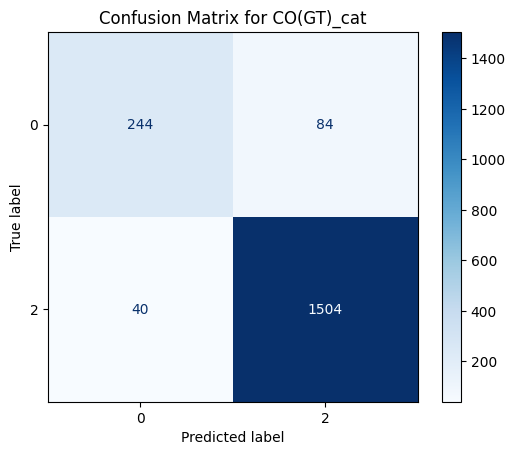

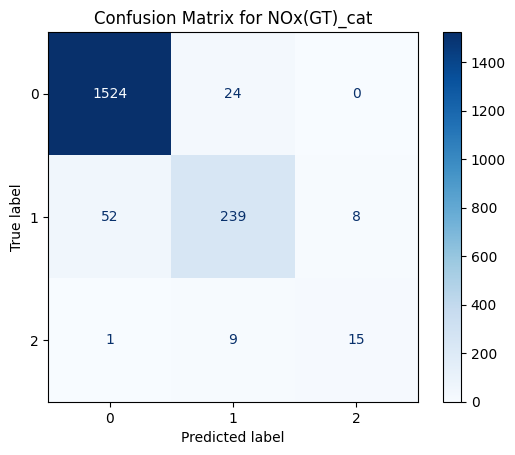

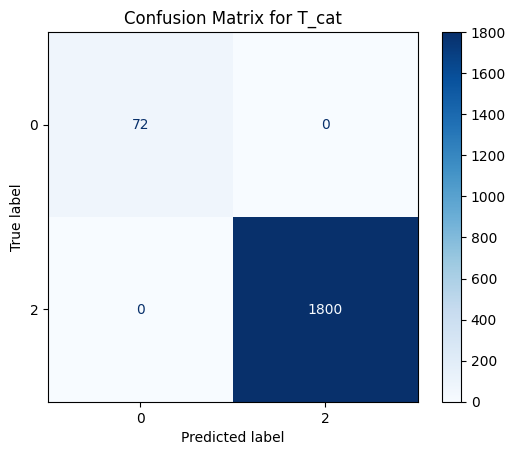

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for i, col in enumerate(Y_processed.columns):
    cm = confusion_matrix(Y_test.iloc[:, i], Y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(Y_processed[col]))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {col}')
    plt.show()


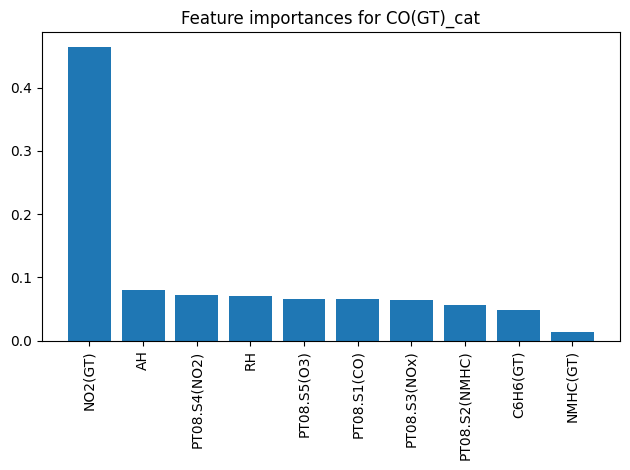

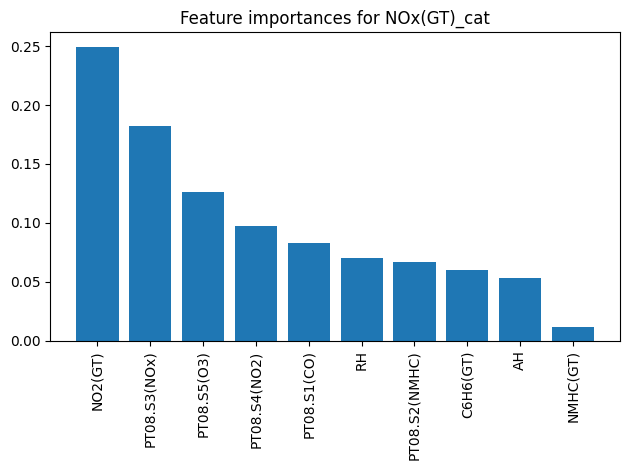

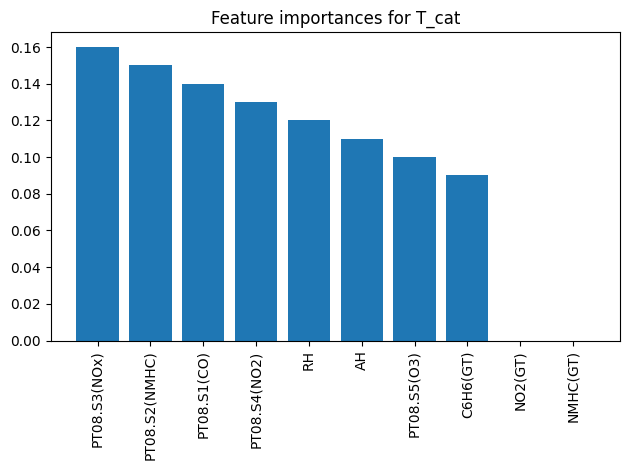

In [ ]:
for i, estimator in enumerate(multi_clf.estimators_):
    importances = estimator.feature_importances_
    indices = importances.argsort()[::-1]
    plt.figure()
    plt.title(f"Feature importances for {Y_processed.columns[i]}")
    plt.bar(range(X_processed.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_processed.shape[1]), X_processed.columns[indices], rotation=90)
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier with balanced class weight
forest_balanced = RandomForestClassifier(random_state=42, class_weight='balanced')

# Wrap with MultiOutputClassifier for multioutput prediction
multi_clf_balanced = MultiOutputClassifier(forest_balanced)

# Train the classifier with balanced class weights
multi_clf_balanced.fit(X_train, Y_train)

# Predict on test set
Y_pred_balanced = multi_clf_balanced.predict(X_test)

# Evaluate your model as before
from sklearn.metrics import classification_report

for i, col in enumerate(Y_processed.columns):
    print(f"Classification report for {col} with balanced class weights:")
    print(classification_report(Y_test.iloc[:, i], Y_pred_balanced[:, i]))


Classification report for CO(GT)_cat with balanced class weights:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       328
           2       0.95      0.98      0.96      1544

    accuracy                           0.94      1872
   macro avg       0.91      0.86      0.88      1872
weighted avg       0.93      0.94      0.93      1872

Classification report for NOx(GT)_cat with balanced class weights:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1548
           1       0.88      0.80      0.83       299
           2       0.64      0.64      0.64        25

    accuracy                           0.95      1872
   macro avg       0.83      0.81      0.82      1872
weighted avg       0.95      0.95      0.95      1872

Classification report for T_cat with balanced class weights:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define parameter distribution for RandomForest
param_dist = {
    'estimator__n_estimators': randint(50, 200),
    'estimator__max_depth': randint(5, 30),
    'estimator__min_samples_split': randint(2, 10),
    'estimator__min_samples_leaf': randint(1, 5),
    'estimator__max_features': ['sqrt', 'log2'] # Corrected 'auto' to 'sqrt'
}

# Initialize base classifier and multioutput wrapper
base_forest = RandomForestClassifier(random_state=42, class_weight='balanced')
multi_clf = MultiOutputClassifier(base_forest)

# Setup RandomizedSearchCV with 5-fold cross-validation and n_iter=20 trials
random_search = RandomizedSearchCV(multi_clf, param_distributions=param_dist, n_iter=20, cv=5, scoring='f1_macro', verbose=2, n_jobs=-1, random_state=42)

# Fit on training data (optionally use resampled data)
random_search.fit(X_train, Y_train)

# Best estimator from search
best_model = random_search.best_estimator_

# Predict on test set with best model
Y_pred_tuned = best_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import classification_report
for i, col in enumerate(Y_processed.columns):
    print(f"Classification report for {col} after hyperparameter tuning:")
    print(classification_report(Y_test.iloc[:, i], Y_pred_tuned[:, i]))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Classification report for CO(GT)_cat after hyperparameter tuning:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       328
           2       0.95      0.96      0.96      1544

    accuracy                           0.93      1872
   macro avg       0.88      0.87      0.88      1872
weighted avg       0.93      0.93      0.93      1872

Classification report for NOx(GT)_cat after hyperparameter tuning:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1548
           1       0.83      0.89      0.86       299
           2       0.58      0.72      0.64        25

    accuracy                           0.95      1872
   macro avg       0.80      0.86      0.83      1872
weighted avg       0.95      0.95      0.95      1872

Classification report for T_cat after hyperparameter tuning:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00